# NLP model building

Purpose : Building a model able to do a classification on sentences

## 0 - Interesting links

* https://www.youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S
* https://www.youtube.com/watch?v=Y_hzMnRXjhI&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=3
* https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/#:~:text=Keras%20offers%20an%20Embedding%20layer%20that%20can%20be,using%20the%20Tokenizer%20API%20also%20provided%20with%20Keras.
* 
https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb#scrollTo=3u8UB0MCkZ5N
* https://towardsdatascience.com/a-practical-introduction-to-keras-callbacks-in-tensorflow-2-705d0c584966

## 1 - Libraries import

In [1]:
import json
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

## 2 - Variables definition

In [2]:
nb_train = 20000 # Number of training examples considered
nb_valid = 5000 # Number of validation examples considered
vocab_size = 10000 # Number of words to be considered regarding on their frequency
max_length = 100 # Maximum length of a sentence --> Size of entrance of neural network
embedding_dim = 32 # Embedding dimension for vector representation of words
nb_epochs = 30 # Number of epochs for training

## 3 - Training JSON file reading

In [3]:
training_examples = []
URL = []
X = [] # sentences
Y = [] # sarcastic or not

for line in open('sarcasm_training_dataset.json', 'r'):
    training_examples.append(json.loads(line))

for item in training_examples:
    X.append(item['headline'])    
    Y.append(item['is_sarcastic'])
    URL.append(item['article_link'])

## 4 - Training / Test dataset splitting

In [4]:
X_train = X[0:nb_train]
Y_train = Y[0:nb_train]

X_valid = X[nb_train:nb_train + nb_valid]
Y_valid = Y[nb_train:nb_train + nb_valid]

X_test = X[nb_train + nb_valid:]
Y_test = Y[nb_train + nb_valid:]

## 5 - Sentences tokenization

In [5]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words = vocab_size) # Strategy for considering Out Of Vocabulary words
tokenizer.fit_on_texts(X_train) # Only considering words in training examples
word_index = tokenizer.word_index

# Pre-processing training set:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_length, padding = 'post', truncating = 'post')

# Pre-processing validation set:
X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen = max_length, padding = 'post', truncating = 'post')

# Pre-processing test set:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length, padding = 'post', truncating = 'post')

## 6 - Model architecture definition

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                792       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 320,817
Trainable params: 320,817
Non-trainable params: 0
_________________________________________________________________


## 7 - Model training

In [9]:
callback_list = []

callback_list.append(EarlyStopping(monitor = 'val_accuracy', patience = 5, min_delta = 0.0, mode = 'max')) # Callback to ensure parameters update in accordance with test accuracy improvement
callback_list.append(CSVLogger('training_log.csv')) # Callback to get a feedback

In [10]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

history = model.fit(X_train, Y_train, epochs = nb_epochs, validation_data = (X_valid, Y_valid), verbose = 2, callbacks = callback_list)

Epoch 1/30
625/625 - 8s - loss: 0.6420 - accuracy: 0.6198 - val_loss: 0.5074 - val_accuracy: 0.8124
Epoch 2/30
625/625 - 6s - loss: 0.3876 - accuracy: 0.8462 - val_loss: 0.3709 - val_accuracy: 0.8360
Epoch 3/30
625/625 - 6s - loss: 0.2863 - accuracy: 0.8866 - val_loss: 0.3398 - val_accuracy: 0.8602
Epoch 4/30
625/625 - 6s - loss: 0.2360 - accuracy: 0.9081 - val_loss: 0.3599 - val_accuracy: 0.8396
Epoch 5/30
625/625 - 6s - loss: 0.2028 - accuracy: 0.9230 - val_loss: 0.3574 - val_accuracy: 0.8446
Epoch 6/30
625/625 - 6s - loss: 0.1746 - accuracy: 0.9348 - val_loss: 0.3549 - val_accuracy: 0.8550
Epoch 7/30
625/625 - 6s - loss: 0.1529 - accuracy: 0.9445 - val_loss: 0.3749 - val_accuracy: 0.8508
Epoch 8/30
625/625 - 6s - loss: 0.1366 - accuracy: 0.9505 - val_loss: 0.3921 - val_accuracy: 0.8526


## 8 - Model training analysis

### 8.1 - Accuracy & Loss plots

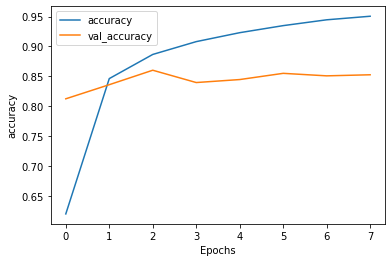

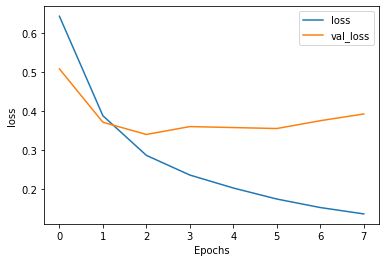

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy") 
plot_graphs(history, "loss")

### 8.2 - Loading log file information

In [12]:
df_log = pd.read_csv('training_log.csv')
df_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.61985,0.641999,0.8124,0.507409
1,1,0.84620,0.387561,0.8360,0.370921
2,2,0.88660,0.286270,0.8602,0.339767
3,3,0.90805,0.235956,0.8396,0.359853
4,4,0.92300,0.202784,0.8446,0.357390
5,5,0.93480,0.174617,0.8550,0.354900
6,6,0.94455,0.152872,0.8508,0.374908
7,7,0.95050,0.136572,0.8526,0.392122


## 9 - Predictions on test set & new sentences

In [13]:
Y_test_prediction = np.round_(model.predict(X_test)[:,0])
conf_matrix = confusion_matrix(Y_test_prediction, Y_test)

print('CONFUSION MATRIX' + '\n' + '='*20)
print('TRUE POSITIVES : ' + str(conf_matrix[0][0]) + '\nFALSE POSITIVES : ' + str(conf_matrix[0][1]) + '\nFALSE NEGATIVES : ' + str(conf_matrix[1][0]) + '\nTRUE NEGATIVES : ' + str(conf_matrix[1][1]))
print('-'*20 + '\nACCURACY : ' + str(np.round_(100 * (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][0] + conf_matrix[0][1] + conf_matrix[1][1]),2)) + ' %')

CONFUSION MATRIX
TRUE POSITIVES : 855
FALSE POSITIVES : 153
FALSE NEGATIVES : 108
TRUE NEGATIVES : 593
--------------------
ACCURACY : 84.73 %


In [14]:
sentence = ["granny starting to fear spiders in the garden might be real"]
sequence = tokenizer.texts_to_sequences(sentence)
sentence = pad_sequences(sequence, maxlen = max_length, padding = 'post', truncating = 'post')

print(np.round_(model.predict(sentence)))

[[1.]]


## 10 - Model parameters save 

In [15]:
model.save("model.h5")

## 11 - Saved model loading

In [16]:
model = load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                792       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 320,817
Trainable params: 320,817
Non-trainable params: 0
_________________________________________________________________
